# ICR - Identifying Age-Related Conditions
Use Machine Learning to detect conditions with measurements of anonymous characteristics.

## Goal of the Competition

The goal of this competition is to predict if a person has any of three medical conditions. You are being asked to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). You will create a model trained on measurements of health characteristics.

To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

Your work will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

## Context

They say age is just a number but a whole host of health issues come with aging. From heart disease and dementia to hearing loss and arthritis, aging is a risk factor for numerous diseases and complications. The growing field of bioinformatics includes research into interventions that can help slow and reverse biological aging and prevent major age-related ailments. Data science could have a role to play in developing new methods to solve problems with diverse data, even if the number of samples is small.

Currently, models like XGBoost and random forest are used to predict medical conditions yet the models' performance is not good enough. Dealing with critical problems where lives are on the line, models need to make correct predictions reliably and consistently between different cases.

Founded in 2015, competition host InVitro Cell Research, LLC (ICR) is a privately funded company focused on regenerative and preventive personalized medicine. Their offices and labs in the greater New York City area offer state-of-the-art research space. InVitro Cell Research's Scientists are what set them apart, helping guide and defining their mission of researching how to repair aging people fast.

In this competition, you’ll work with measurements of health characteristic data to solve critical problems in bioinformatics. Based on minimal training, you’ll create a model to predict if a person has any of three medical conditions, with an aim to improve on existing methods.

You could help advance the growing field of bioinformatics and explore new methods to solve complex problems with diverse data.

In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score, log_loss, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

colors_blue = ["#132C33", "#264D58", '#17869E', '#51C4D3', '#B4DBE9']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
colors_red = ['#FF0000', '#FF3333', '#FF6666', '#FF9999', '#FFCCCC']
colors_orange = ['#FF6600', '#FF8000', '#FF9900', '#FFB200', '#FFCC00']

# Set default settings
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
#Set the font family
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10 # set default size of plots

pd.set_option('display.max_rows', 2536)
pd.set_option('display.max_columns', 100)

### Importing the datasets

In [2]:
# IMPORTING DATA
train_df  = pd.read_csv('../Data/train.csv', encoding='utf-8')
greeks_df = pd.read_csv('../Data/greeks.csv', encoding='utf-8')
test_df   = pd.read_csv('../Data/test.csv', encoding='utf-8')

# Renaming columns
train_df.columns  = [x.lower().replace(" ", "") for x in train_df.columns]
greeks_df.columns = [x.lower().replace(" ", "") for x in greeks_df.columns]
test_df.columns   = [x.lower().replace(" ", "") for x in test_df.columns]

# Features
train_features = list(train_df.drop(['id', 'class'], axis=1).columns)

target = 'class'

### EXPLORATORY DATA ANALYSIS

#### Train set

In [3]:
# How much memory the dataset takes?

train_df.info(memory_usage='deep') # memory_usage parameter allows us to see the real memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      617 non-null    object 
 1   ab      617 non-null    float64
 2   af      617 non-null    float64
 3   ah      617 non-null    float64
 4   am      617 non-null    float64
 5   ar      617 non-null    float64
 6   ax      617 non-null    float64
 7   ay      617 non-null    float64
 8   az      617 non-null    float64
 9   bc      617 non-null    float64
 10  bd      617 non-null    float64
 11  bn      617 non-null    float64
 12  bp      617 non-null    float64
 13  bq      557 non-null    float64
 14  br      617 non-null    float64
 15  bz      617 non-null    float64
 16  cb      615 non-null    float64
 17  cc      614 non-null    float64
 18  cd      617 non-null    float64
 19  cf      617 non-null    float64
 20  ch      617 non-null    float64
 21  cl      617 non-null    float64
 22  cr

In [4]:
greeks_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       617 non-null    object
 1   alpha    617 non-null    object
 2   beta     617 non-null    object
 3   gamma    617 non-null    object
 4   delta    617 non-null    object
 5   epsilon  617 non-null    object
dtypes: object(6)
memory usage: 221.0 KB


In [5]:
#train_df = pd.merge(train_df, greeks_df, how='left', on='id')

# Descriptive statistics
train_df.head()

id        ab          af          ah         am        ar  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         ax        ay         az          bc          bd       bn          bp  \
0  0.699861  0.025578   9.812214    5.555634  4126.58731  22.5984  175.638726   
1  3.632190  0.025578  13.517790    1.229900  5496.92824  19.4205  155.868030   
2  6.732840  0.025578  12.824570    1.229900  5135.78024  26.4825  128.988531   
3  3.685344  0.025578  11.053708    1.229900  4169.67738  23.6577  237.282264   
4  3.942255  0.054810   3.396778  102.151980  5728.73412  24.0108  324.546318   

           bq           br          bz         cb        cc         cd  \
0  152.707705   823.928241  257.432377  47.223358  0.563481  23.387600   
1   14.754720    51.216883  257.432377  30.284345  0.484710  50.628208   
2  219.320160   482.141594  257.432377  32.563713  0.495852  85.955376   
3   11.050410   661.518640  257.432377  15.201914  0.717882  88.159360   
4  149.717165  6074.859475  257.432377  82.213495  0.536467  72.644264   

          cf        ch        cl        cr         cs        cu         cw  \
0   4.851915  0.023482  1.050225  0.069225  13.784111  1.302012  36.205956   
1   6.085041  0.031442  1.113875  1.117800  28.310953  1.357182  37.476568   
2   5.376488  0.036218  1.050225  0.700350  39.364743  1.009611  21.459644   
3   2.347652  0.029054  1.400300  0.636075  41.116960  0.722727  21.530392   
4  30.537722  0.025472  1.050225  0.693150  31.724726  0.827550  34.415360   

         da          de       df        dh          di        dl         dn  \
0  69.08340  295.570575  0.23868  0.284232   89.245560  84.31664  29.657104   
1  70.79836  178.553100  0.23868  0.363489  110.581815  75.74548  37.532000   
2  70.81970  321.426625  0.23868  0.210441  120.056438  65.46984  28.053464   
3  47.27586  196.607985  0.23868  0.292431  139.824570  71.57120  24.354856   
4  74.06532  200.178160  0.23868  0.207708   97.920120  52.83888  26.019912   

         du       dv         dy        eb        ee            eg        eh  \
0  5.310690  1.74307  23.187704  7.294176  1.987283   1433.166750  0.949104   
1  0.005518  1.74307  17.222328  4.926396  0.858603   1111.287150  0.003042   
2  1.289739  1.74307  36.861352  7.813674  8.146651   1494.076488  0.377208   
3  2.655345  1.74307  52.003884  7.386060  3.813326  15691.552180  0.614484   
4  1.144902  1.74307   9.064856  7.350720  3.490846   1403.656300  0.164268   

  ej          el         ep         eu          fc         fd            fe  \
0  B   30.879420  78.526968   3.828384   13.394640  10.265073   9028.291921   
1  A  109.125159  95.415086  52.260480   17.175984   0.296850   6785.003474   
2  B  109.125159  78.526968   5.390628  224.207424   8.745201   8338.906181   
3  B   31.674357  78.526968  31.323372   59.301984   7.884336  10965.766040   
4  B  109.125159  91.994825  51.141336   29.102640   4.274640  16198.049590   

          fi        fl        fr        fs         gb          ge  \
0   3.583450  7.298162   1.73855  0.094822  11.339138   72.611063   
1  10.358927  0.173229   0.49706  0.568932   9.292698   72.611063   
2  11.626917  7.709560   0.97556  1.198821  37.077772   88.609437   
3  14.852022  6.122162   0.49706  0.284466  18.529584   82.416803   
4  13.666727  8.153058  48.50134  0.121914  16.408728  146.109943   

             gf         gh         gi         gl  class  
0   2003.810319  22.136229  69.834944   0.120343      1  
1  27981.562750  29.135430  32.131996  21.978000      0  
2  13676.957810  28.022851  35.192676   0.196941      0  
3   2094.262452  39.948656  90.493248   0.155829      0  
4   8524.370502  45.381316  36.262628

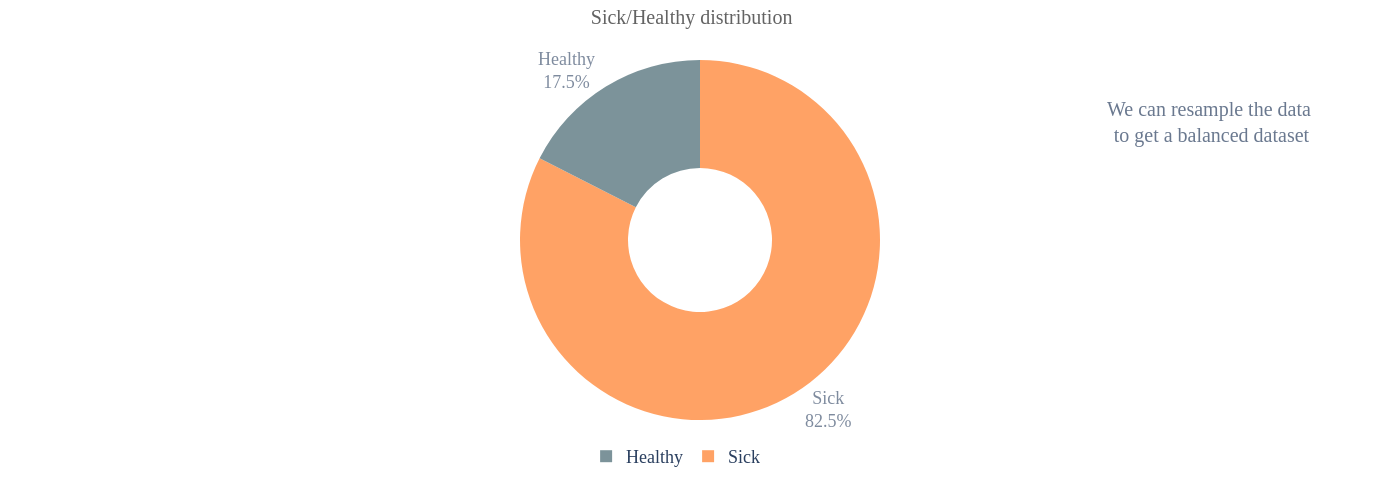

In [6]:
# Check class distribution

d= pd.DataFrame(train_df['class'].value_counts())
fig = px.pie(d,values='count',names=['Sick','Healthy'],hole=0.4,opacity=0.6,
            color_discrete_sequence=[colors_orange[0],colors_blue[1]],
             labels={'label':'','Healthy':'No. Of Samples'})

fig.add_annotation(text='We can resample the data<br> to get a balanced dataset',
                   x=1.2,y=0.9,showarrow=False,font_size=20,opacity=0.7,font_family='Times New Roman')
fig.add_annotation(text='',
                   x=0.5,y=0.5,showarrow=False,font_size=20,opacity=0.7,font_family='Times New Roman')

fig.update_layout(
    font=dict(
        family='Times New Roman',
        size=18
    ),
    title=dict(text='Sick/Healthy distribution',x=0.494,y=0.98,
               font=dict(color=colors_dark[2],size=20)),
    legend=dict(x=0.37,y=-0.05,orientation='h',traceorder='reversed'),
    hoverlabel=dict(bgcolor='white'))

fig.update_traces(textposition='outside', textinfo='percent+label')

fig.show("png", width=1400, height=500)

Because of EJ is the unique string type data let's inspect EJ feature and encode it in some way.

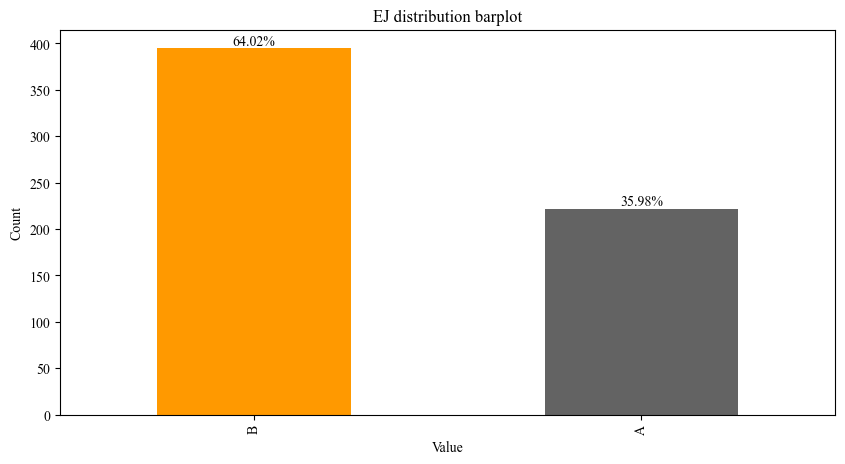

In [7]:
# Calcola il conteggio dei valori
value_counts = train_df['ej'].value_counts()

# Crea il barplot
ax = value_counts.plot(kind='bar', color=[colors_orange[-3], colors_dark[-3]], figsize=(10, 5))

# Aggiungi le etichette percentuali ai barplot
total = len(train_df['ej'])
for i, count in enumerate(value_counts):
    percentage = (count / total) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')

# Aggiungi altre personalizzazioni se necessario
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('EJ distribution barplot')

# Mostra il grafico
plt.show()

We can convert this feature to categorical one.

In [8]:
train_df['ej'] = train_df['ej'].map({'A': 1, 'B': 0})
train_df['ej'] = pd.to_numeric(train_df['ej'])

#### Correlation heatmap

A graphical representation of a correlation matrix representing the Pearson correlation between different variables.

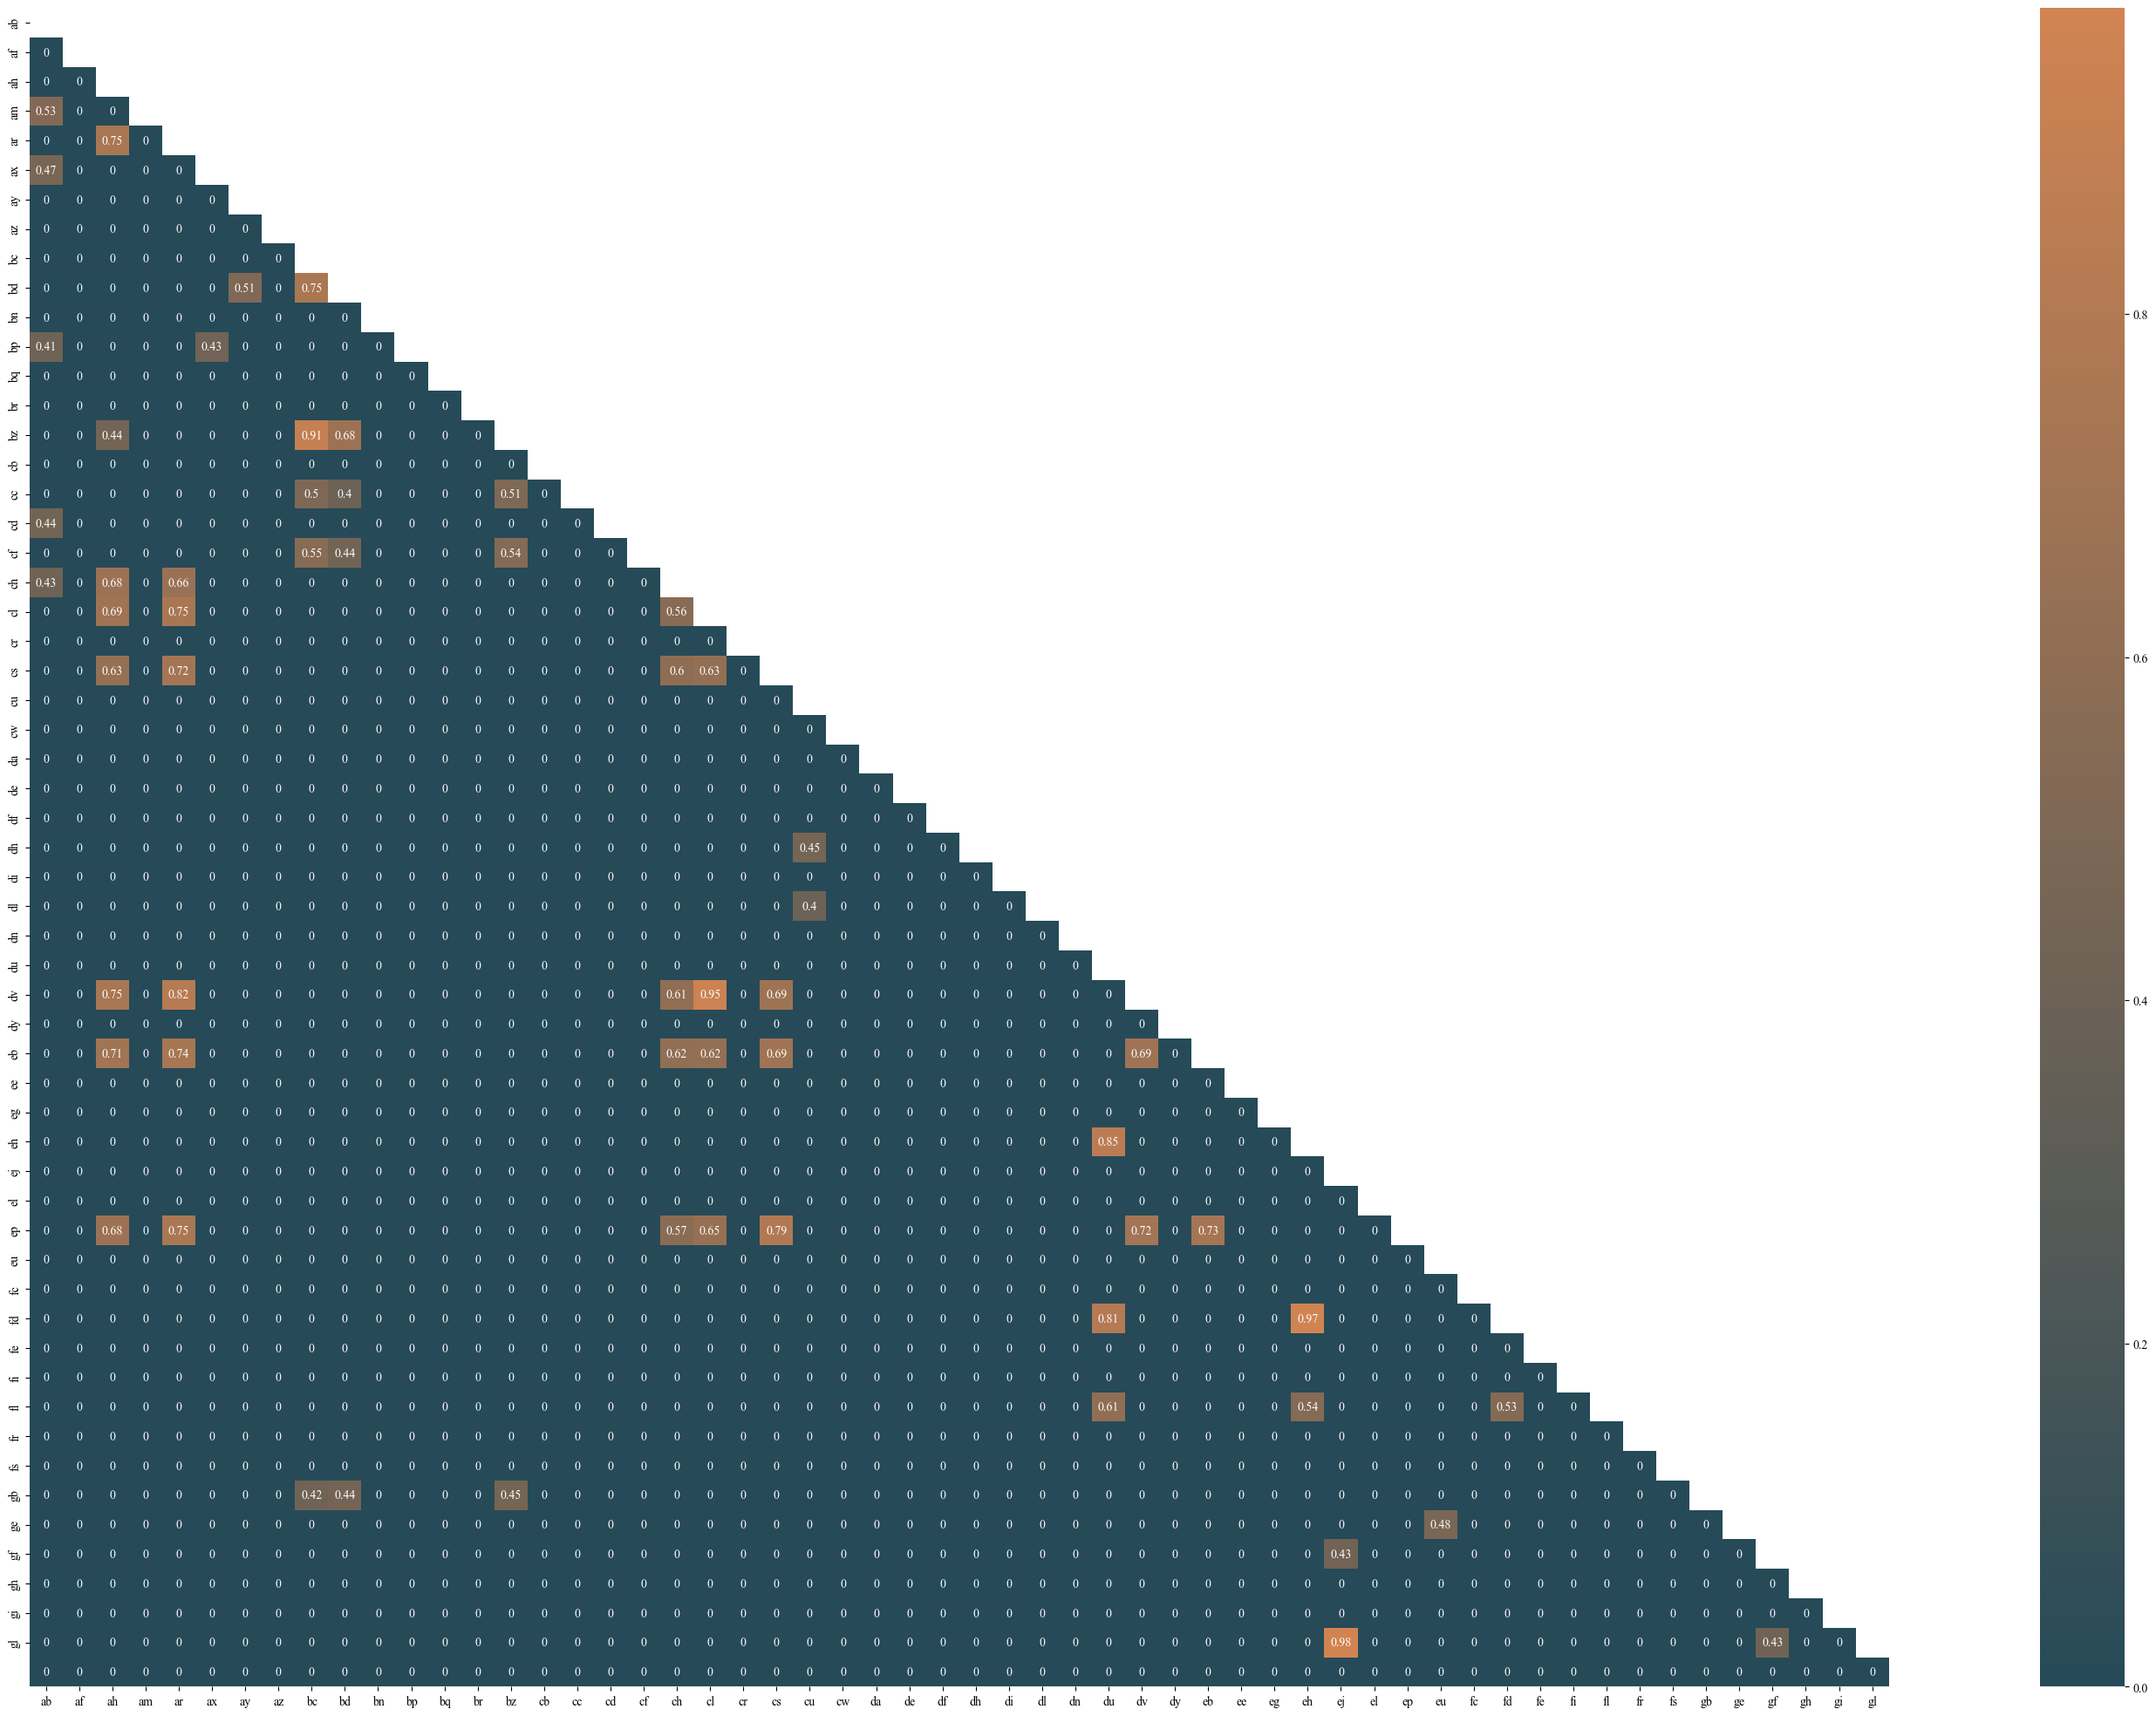

In [9]:
# Set the default figure size
plt.rcParams['figure.figsize'] = (35.0, 25)

# Generating a colormap with adjusted saturation
custom_cmap = sns.diverging_palette(220, 20, s=50, l=50, sep=2, as_cmap=True)

# Adding the custom colors to the colormap
custom_cmap = custom_cmap.from_list('custom_colormap', ["#264A58", '#d18452'])

# Calculate the correlation matrix
corr = train_df[train_features + [target]].corr()

# Initialize an empty heatmap matrix
heatmap = np.zeros_like(corr)

# Set the significance threshold
threshold = 0.4  # Adjust as needed

# Update the heatmap matrix with only significant correlations
for i in range(len(train_features)):
    for j in range(len(train_features)):
        if i != j:
            correlation = corr.iloc[i, j]
            if abs(correlation) >= threshold:
                heatmap[i, j] = correlation

# Create a mask for the heatmap
mask = np.triu(np.ones_like(heatmap, dtype=bool))

# Create the heatmap with significant correlations
sns.heatmap(heatmap, xticklabels=train_features, yticklabels=train_features, annot=True, cmap=custom_cmap, mask=mask)

# Show the plot
plt.show()

## Feature pre-processing

I decided to dro these columns due to high correlation between others: ej, fd, cl, bz

In [10]:
train_df.drop(['ej', 'fd', 'cl', 'bz'], axis=1, inplace=True)
train_features = list(train_df.drop(['id', 'class'], axis=1).columns)

Let's check the null values.

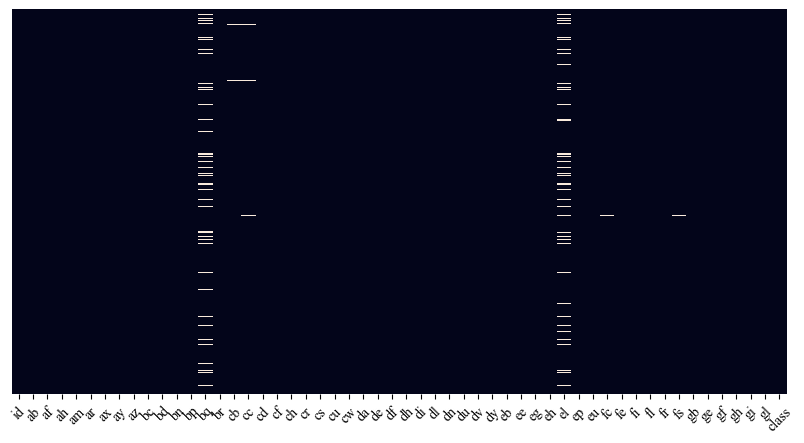

In [11]:
plt.rcParams['figure.figsize'] = (10.0, 5)

# Creazione del grafico dei valori mancanti utilizzando Seaborn
sns.heatmap(train_df.isnull(), cbar=False, yticklabels=False)
plt.xticks(rotation=45)
plt.show()

Let's analyze the 2 features with a lot of missing values (el, bq). This analysis can help for finding the best way to fit null values.

EL

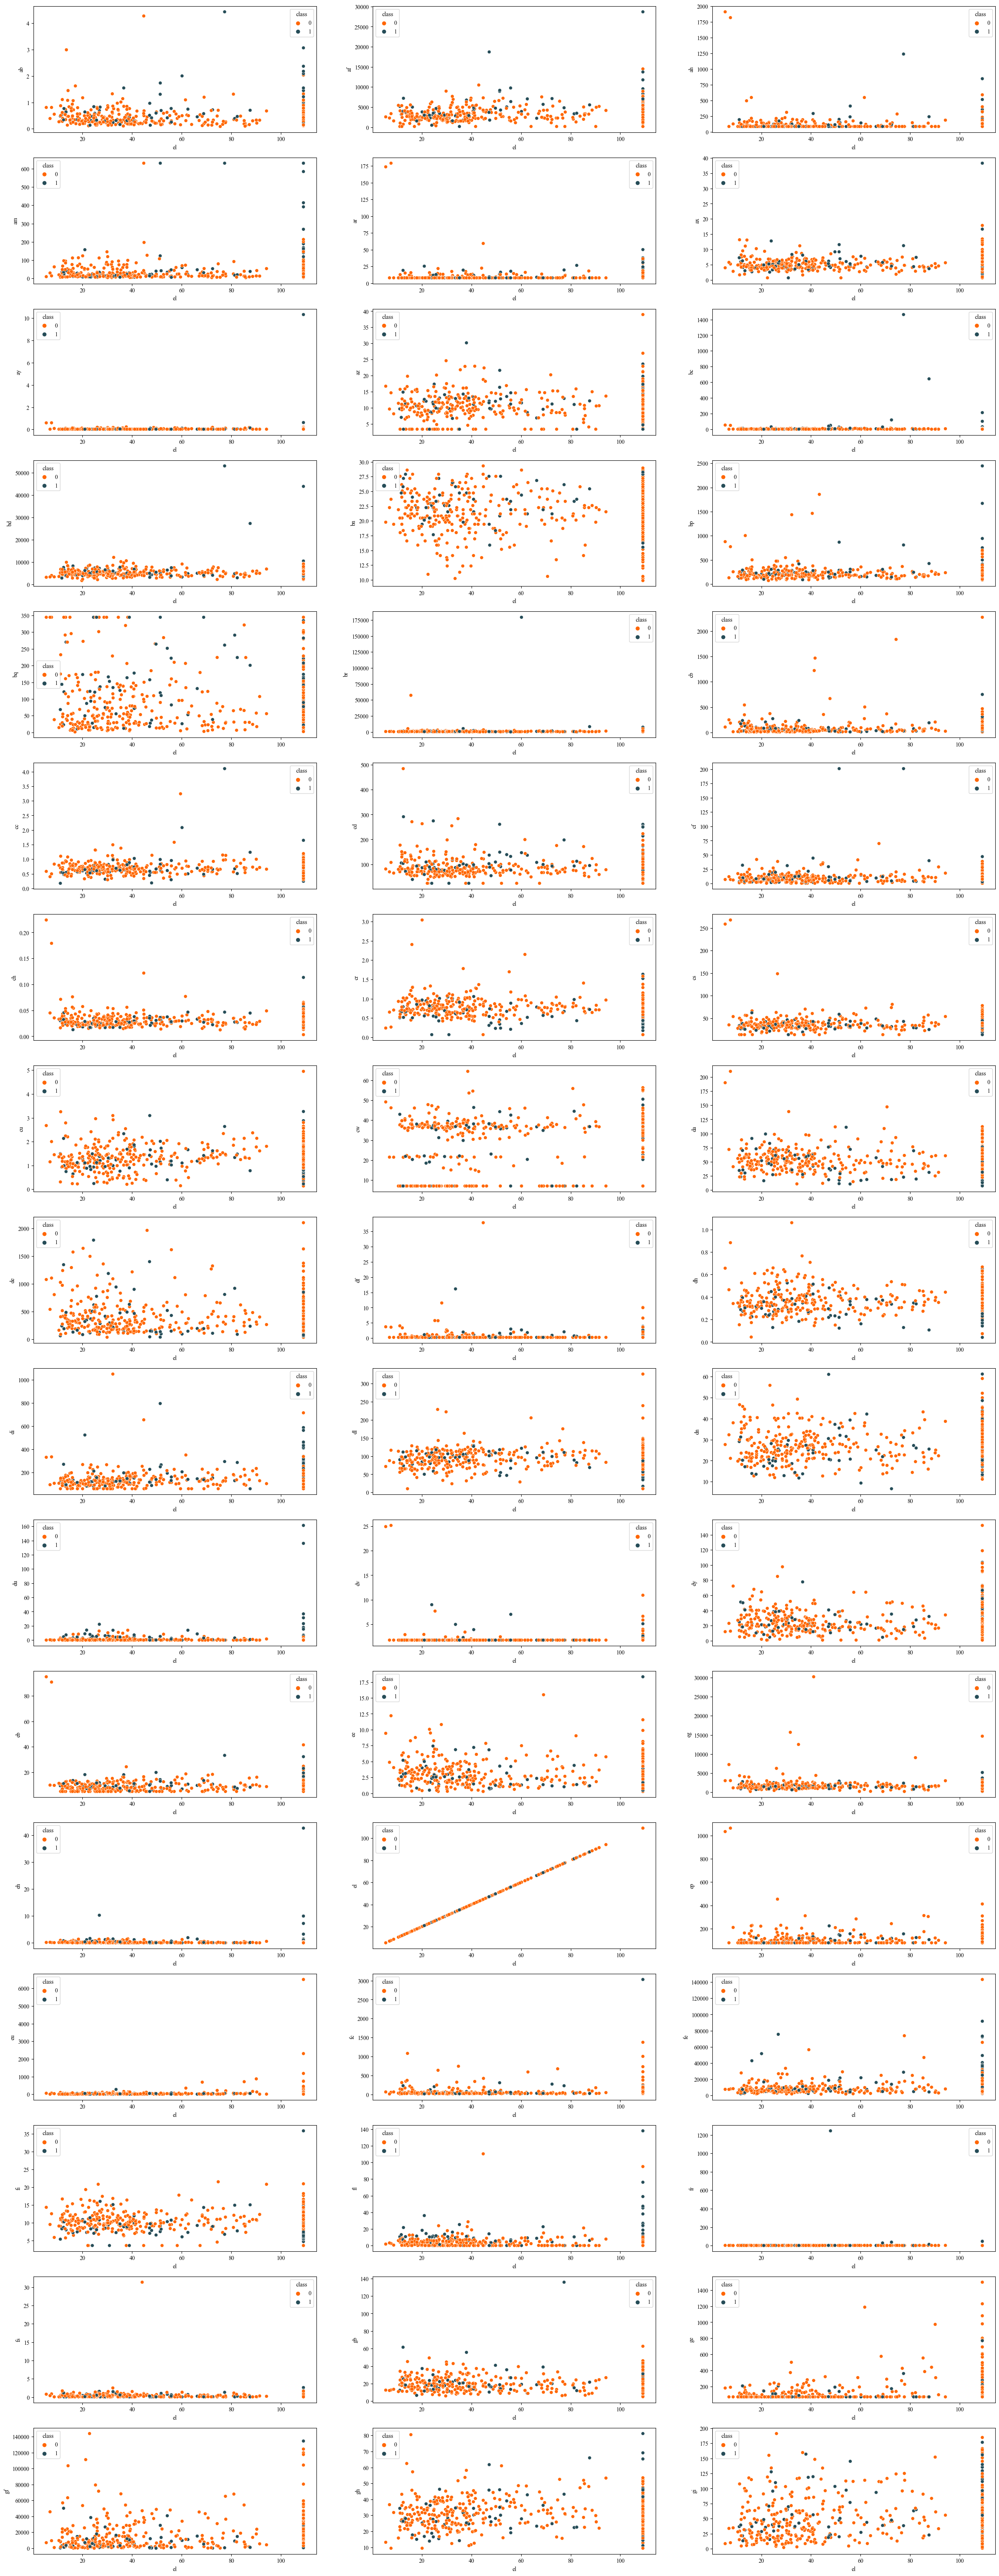

In [12]:
plt.rcParams['figure.figsize'] = (30.0, 80)

fig, axs = plt.subplots(ncols=3, nrows=17, sharey=False)

for i in range(17):
    for k in range(3):
        sns.scatterplot(x='el', y=train_features[3*i + k], hue=target, data=train_df, ax=axs[i][k], palette=[colors_orange[0], colors_blue[1]])

#plt.savefig('feature-scatterplot.png', dpi=300)
plt.show()

BQ

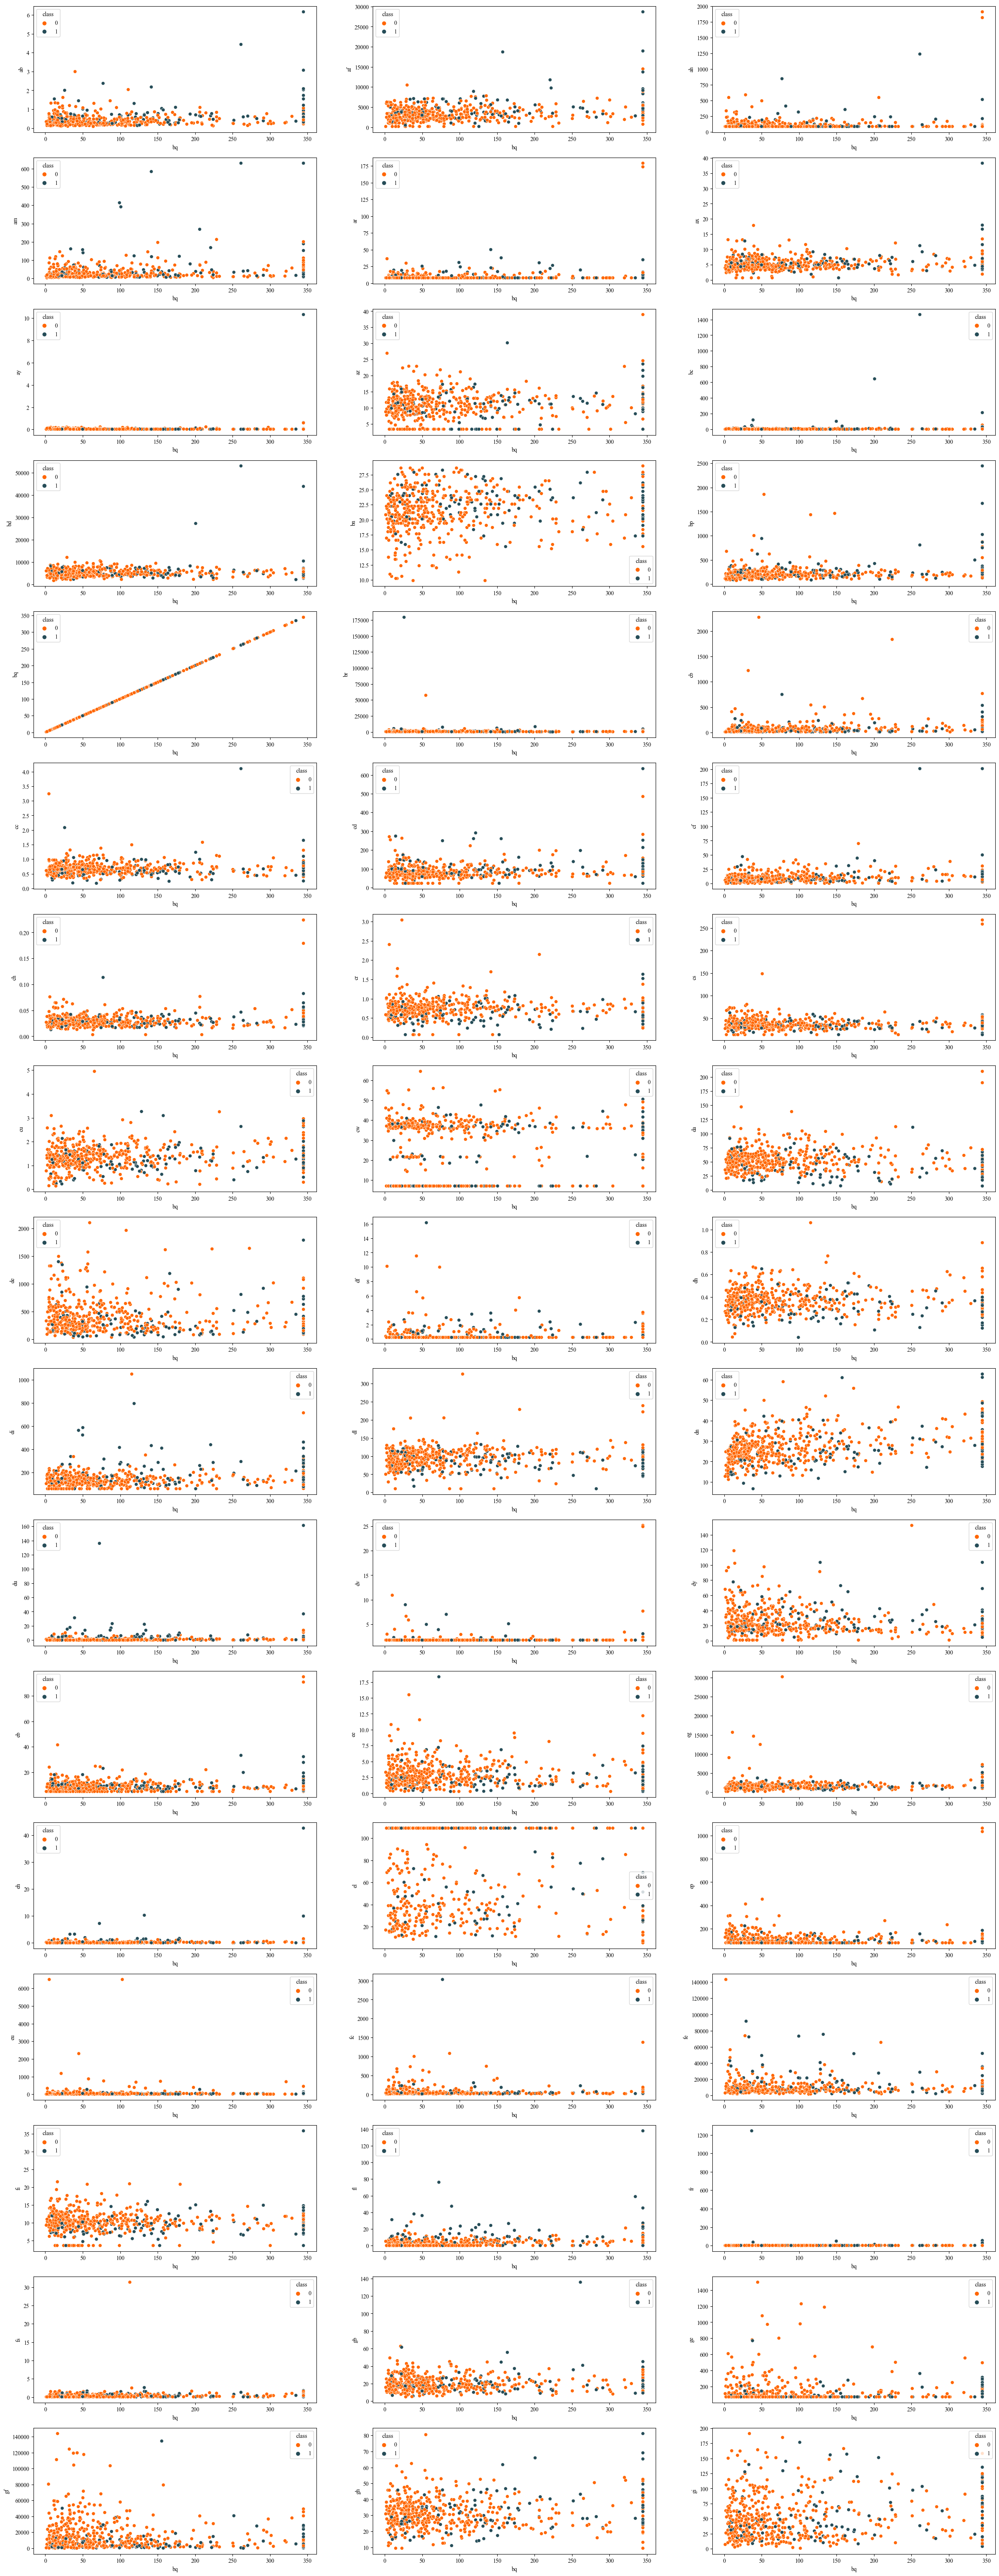

In [13]:
plt.rcParams['figure.figsize'] = (30.0, 80)

fig, axs = plt.subplots(ncols=3, nrows=17, sharey=False)

for i in range(17):
    for k in range(3):
        sns.scatterplot(x='bq', y=train_features[3*i + k], hue=target, data=train_df, ax=axs[i][k], palette=[colors_orange[0], colors_blue[1]])

#plt.savefig('feature-scatterplot.png', dpi=300)
plt.show()

The above graphs (and the heatmap as well) shows that there isn't a significant correlation between these 2 features with each others. 
Let's drop the null values in this two columns.

In [14]:
train_df.drop(['el', 'bq'], axis=1, inplace=True)
train_df.dropna(inplace=True)

#Update feature names
train_features = list(train_df.drop(['id', 'class'], axis=1).columns)

#### Analyze greeks

Add class column to the greek dataframe and drop epsilon column

In [15]:
greeks_df.drop("epsilon", inplace=True, axis=1)
greeks_df = pd.merge(train_df[['id', 'class']], greeks_df, how='left', on='id')

greeks_features = ['alpha', 'beta', 'gamma', 'delta']

/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



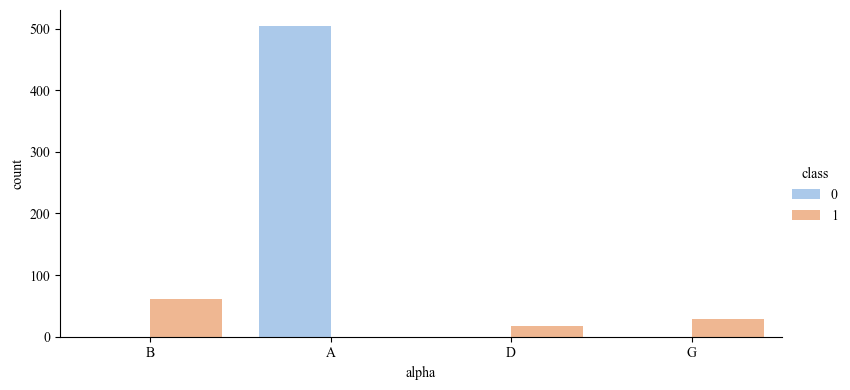

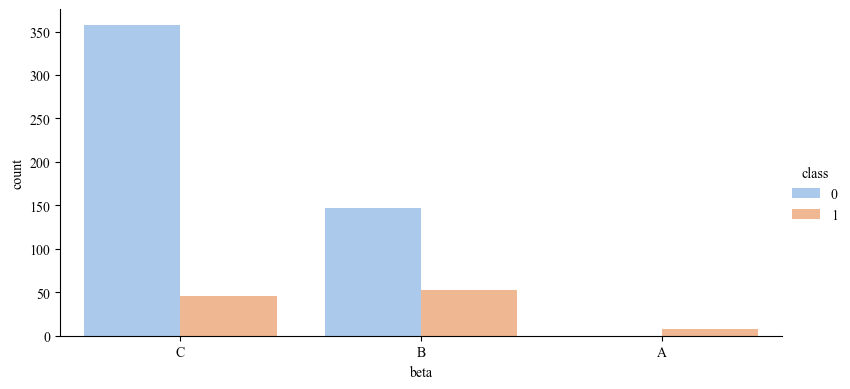

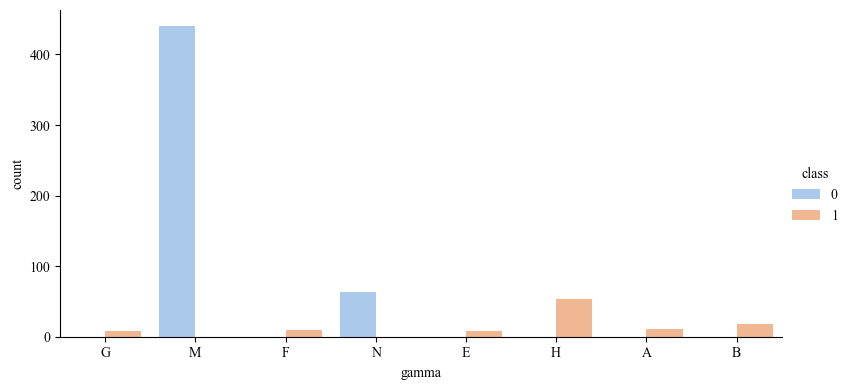

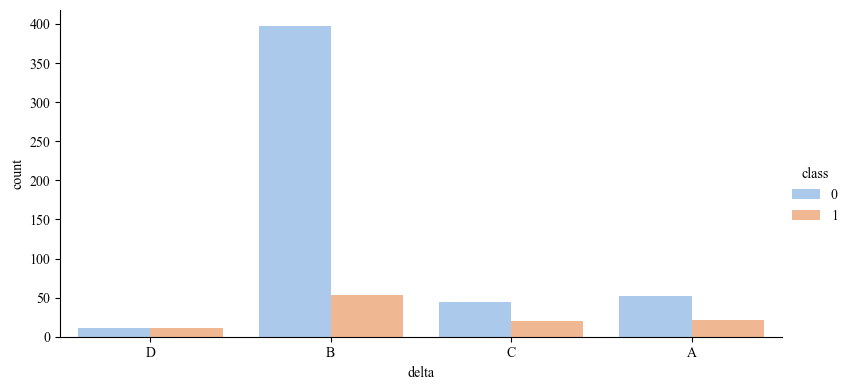

In [16]:
# Create bar plots for each categorical variable
sns.catplot(x="alpha", kind="count", data=greeks_df, palette="pastel", height=4, aspect=2, hue='class')
sns.catplot(x="beta",  kind="count", data=greeks_df, palette="pastel", height=4, aspect=2, hue='class')
sns.catplot(x="gamma", kind="count", data=greeks_df, palette="pastel", height=4, aspect=2, hue='class')
sns.catplot(x="delta", kind="count", data=greeks_df, palette="pastel", height=4, aspect=2, hue='class')

But all of this information are only available with the trainset, so let's go on.

In [17]:
train_df.head()

id        ab          af          ah         am        ar  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         ax        ay         az          bc          bd       bn          bp  \
0  0.699861  0.025578   9.812214    5.555634  4126.58731  22.5984  175.638726   
1  3.632190  0.025578  13.517790    1.229900  5496.92824  19.4205  155.868030   
2  6.732840  0.025578  12.824570    1.229900  5135.78024  26.4825  128.988531   
3  3.685344  0.025578  11.053708    1.229900  4169.67738  23.6577  237.282264   
4  3.942255  0.054810   3.396778  102.151980  5728.73412  24.0108  324.546318   

            br         cb        cc         cd         cf        ch        cr  \
0   823.928241  47.223358  0.563481  23.387600   4.851915  0.023482  0.069225   
1    51.216883  30.284345  0.484710  50.628208   6.085041  0.031442  1.117800   
2   482.141594  32.563713  0.495852  85.955376   5.376488  0.036218  0.700350   
3   661.518640  15.201914  0.717882  88.159360   2.347652  0.029054  0.636075   
4  6074.859475  82.213495  0.536467  72.644264  30.537722  0.025472  0.693150   

          cs        cu         cw        da          de       df        dh  \
0  13.784111  1.302012  36.205956  69.08340  295.570575  0.23868  0.284232   
1  28.310953  1.357182  37.476568  70.79836  178.553100  0.23868  0.363489   
2  39.364743  1.009611  21.459644  70.81970  321.426625  0.23868  0.210441   
3  41.116960  0.722727  21.530392  47.27586  196.607985  0.23868  0.292431   
4  31.724726  0.827550  34.415360  74.06532  200.178160  0.23868  0.207708   

           di        dl         dn        du       dv         dy        eb  \
0   89.245560  84.31664  29.657104  5.310690  1.74307  23.187704  7.294176   
1  110.581815  75.74548  37.532000  0.005518  1.74307  17.222328  4.926396   
2  120.056438  65.46984  28.053464  1.289739  1.74307  36.861352  7.813674   
3  139.824570  71.57120  24.354856  2.655345  1.74307  52.003884  7.386060   
4   97.920120  52.83888  26.019912  1.144902  1.74307   9.064856  7.350720   

         ee            eg        eh         ep         eu          fc  \
0  1.987283   1433.166750  0.949104  78.526968   3.828384   13.394640   
1  0.858603   1111.287150  0.003042  95.415086  52.260480   17.175984   
2  8.146651   1494.076488  0.377208  78.526968   5.390628  224.207424   
3  3.813326  15691.552180  0.614484  78.526968  31.323372   59.301984   
4  3.490846   1403.656300  0.164268  91.994825  51.141336   29.102640   

             fe         fi        fl        fr        fs         gb  \
0   9028.291921   3.583450  7.298162   1.73855  0.094822  11.339138   
1   6785.003474  10.358927  0.173229   0.49706  0.568932   9.292698   
2   8338.906181  11.626917  7.709560   0.97556  1.198821  37.077772   
3  10965.766040  14.852022  6.122162   0.49706  0.284466  18.529584   
4  16198.049590  13.666727  8.153058  48.50134  0.121914  16.408728   

           ge            gf         gh         gi         gl  class  
0   72.611063   2003.810319  22.136229  69.834944   0.120343      1  
1   72.611063  27981.562750  29.135430  32.131996  21.978000      0  
2   88.609437  13676.957810  28.022851  35.192676   0.196941      0  
3   82.416803   2094.262452  39.948656  90.493248   0.155829      0  
4  146.109943   8524.370502  45.381316  36.262628   0.096614      1

Train-test split

In [18]:
X = train_df[train_features].to_numpy()
y = train_df[target].to_numpy()

## Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=0, stratify=y)


$$\LARGE \text{Log Loss} = \frac{-\frac{1}{N_{0}} \sum_{i=1}^{N_{0}} y_{0 i} \log  p_{0 i} - \frac {1}{N_{1}} \sum_{i=1}^{N_{1}} y_{1 i} \log  p_{1 i} } { 2 }$$
    

/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

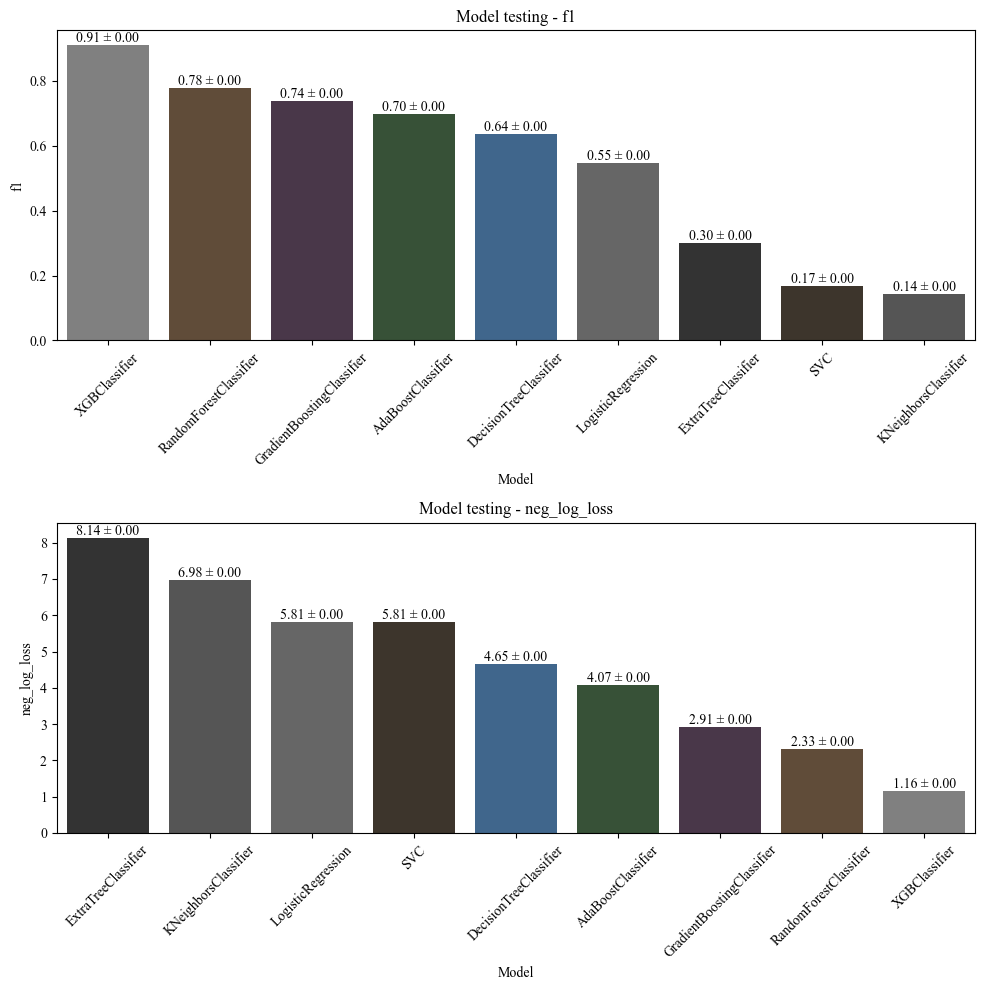

In [26]:
# Model definition
models = [
    LogisticRegression(class_weight='balanced', max_iter=1000),
    DecisionTreeClassifier(class_weight='balanced', random_state=0),
    RandomForestClassifier(random_state=0, class_weight='balanced'),
    XGBClassifier(scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(), random_state=0),
    AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=200, random_state=0),
    KNeighborsClassifier(),
    SVC(random_state=0),
    ExtraTreeClassifier(class_weight='balanced', random_state=0),
    GradientBoostingClassifier(random_state=0),
]

# Metrics definition
metrics = ["f1", "neg_log_loss"]

# List to save results for different metrics
results = {metric: [] for metric in metrics}

# Cross-validation execution for different metrics
for model in models:
    for metric in metrics:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if metric == 'neg_log_loss':
            scores = eval("log_loss" + '(y_test, y_pred)')
        else:
            scores = eval(metric + '_score(y_test, y_pred)')
        results[metric].append(scores)

# Plot creation with Seaborn for different metrics
num_metrics = len(metrics)

model_colors = {
    'LogisticRegression': '#666666',
    'DecisionTreeClassifier': '#336699',
    'GaussianNB': '#5C7E58',
    'RandomForestClassifier': '#664C33',
    'XGBClassifier': '#808080',
    'AdaBoostClassifier': '#335533',
    'GradientBoostingClassifier': '#4C344C',
    'KNeighborsClassifier': '#555555',
    'SVC': '#403529',
    'ExtraTreeClassifier': '#333333',
}

plt.rcParams['figure.figsize'] = (10, 10)

for i, metric in enumerate(metrics):
    # Sorting of models and metrics
    sorted_models = sorted(models, key=lambda model: results[metric][models.index(model)], reverse=True)

    ax = plt.subplot(num_metrics, 1, i + 1)
    metric_results = [results[metric][models.index(model)] for model in sorted_models]

    # Transforming color names into RGBA
    model_colors_rgba = [model_colors[type(model).__name__] for model in sorted_models]

    sns.barplot(x=[type(model).__name__ for model in sorted_models], y=metric_results, palette=model_colors_rgba)
    plt.xticks(rotation=45)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'Model testing - {metric}')

    # Adding percentages on the bars
    for j in range(len(models)):
        scores = metric_results[j]
        mean_score = scores.mean()
        std_score = scores.std()
        text = f'{mean_score:.2f} ± {std_score:.2f}'
        ax.text(j, mean_score, text, ha='center', va='bottom')

plt.tight_layout()

#plt.savefig("model-testing-1.png", dpi=300)
plt.show()

I'll choose the XGBoost classifiers al macine leanring model

In [27]:
# Function to plot feature importance

def plot_feature_importance(model, columns):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(model.feature_importances_)
    feature_names = np.array(columns)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(9,8))

    palette = sns.color_palette("Blues_d",n_colors=9)
    palette.reverse()

    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=palette)
    #Add chart labels
    plt.title(model.__class__.__name__ + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    plt.tight_layout()
    #plt.savefig(model.__class__.__name__ + '-feature-importance.png', dpi=300)
    plt.show()

In [28]:
# Grid search function
def gridsearch(X_train, y_train, parameters, fold, metric, model):

    kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=0)

    grid_search = GridSearchCV(model, param_grid=parameters, cv=kfold, n_jobs=-1, scoring=metric, verbose=3)
    grid_search.fit(X_train, y_train)

    # Printing the best parameters and best score from the grid search
    #print("########## ", metric.upper(), " ##########")
    print("Best parameters found:")
    print(grid_search.best_params_)
    print("Best score:")
    print(grid_search.best_score_)
    
    return grid_search

In [29]:
def balanced_log_loss(y_true, y_pred):
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = (w_0 * log_loss_0 + w_1 * log_loss_1) / 2
    # return the average log loss
    return abs(balanced_log_loss)

In [ ]:
######## Grid search cell #########
# Exec time:  20 min

# Define the parameters for the grid search
parameters = {
                'gamma': [0, 0.5, 1], # It defines how far the influence of a single training example reaches.
                'learning_rate': np.arange(0.1, 0.25, 0.05), # The learning rate shrinks the contribution of each tree.
                'max_depth': [10, 50], # The maximum depth of each tree.
                'n_estimators': [100, 200, 300], # The number of trees in the forest.
                'subsample': [0.6, 0.7, 0.8], # The percentage of samples used.
                'reg_lambda': [10], # L2 regularization.
                'reg_alpha': [1, 5], # L1 regularization.
                'booster': ['dart', 'gbtree', 'gblinear'], # The type of gradient boosting algorithm.
                'random_state': [0], # The seed used by the random number generator.
                'scale_pos_weight': [(len(y_train) - y_train.sum()) / y_train.sum()] # The weight of the positive class
}

# Chose the evaluation metric
metric = make_scorer(balanced_log_loss, greater_is_better=False)

# Fitting the GridSearch
grid_search = gridsearch(X_train, y_train, parameters, 3, metric, XGBClassifier())

In [33]:
# Model fitting
xgb = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, gamma=1, reg_alpha=5,
                    reg_lambda=10, booster='dart', subsample=0.7, random_state=0, 
                    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(), objective="binary:logistic")
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("Log loss:", log_loss(y_test, y_pred))
print(classification_report(y_test, y_pred))

pk.dump(xgb, open('../Models/xgb-100es.pkl', 'wb'))

Log loss: 0.5813492482115672
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.92      1.00      0.96        11

    accuracy                           0.98        62
   macro avg       0.96      0.99      0.97        62
weighted avg       0.99      0.98      0.98        62



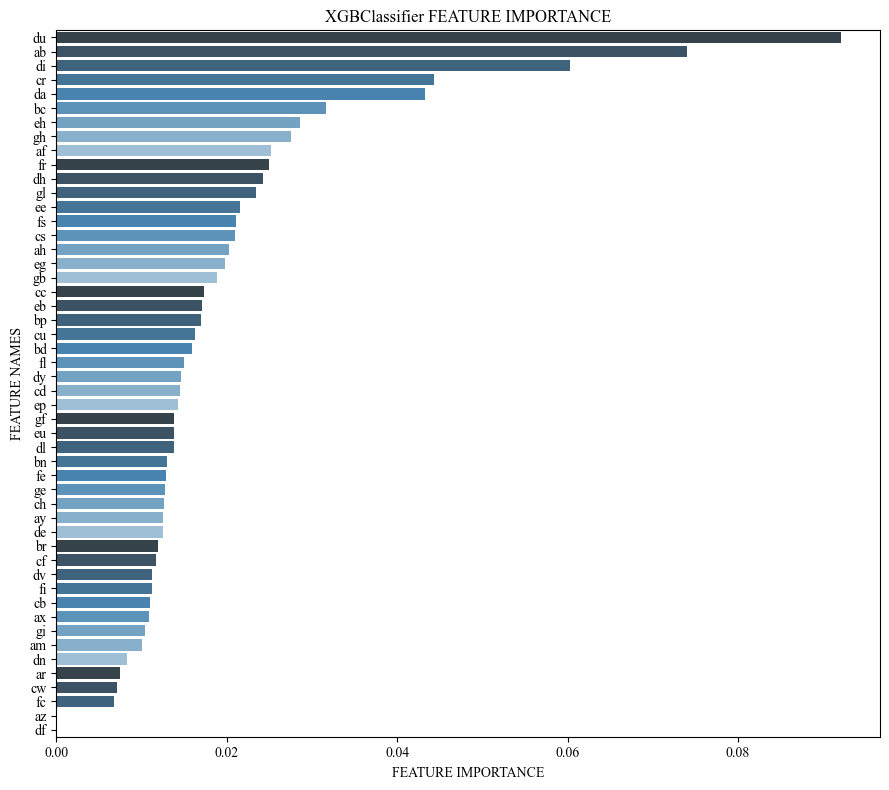

In [34]:
plot_feature_importance(xgb, train_features)

### Submission

In [59]:
test_df.drop(['ej', 'fd', 'cl', 'bz', 'el', 'bq'], axis=1, inplace=True)
test_features = list(test_df.drop(['id'], axis=1).columns)

test_df.head()

id   ab   af   ah   am   ar   ax   ay   az   bc   bd   bn   bp  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    br   cb   cc   cd   cf   ch   cr   cs   cu   cw   da   de   df   dh   di  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    dl   dn   du   dv   dy   eb   ee   eg   eh   ep   eu   fc   fe   fi   fl  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    fr   fs   gb   ge   gf   gh   gi   gl  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [60]:
pd.DataFrame(xgb.predict_proba(test_df[test_features].to_numpy()), columns=['class_0', 'class_1'], index=test_df['id']).reset_index().to_csv('../Results/submission.csv', index=False)